# Tracer for MCMC 

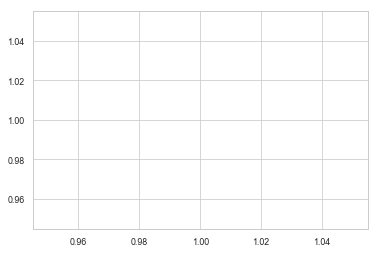

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(1,1)
%matplotlib inline
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})
import ast 
plt.plot(1,1)

In [7]:
# figure setting 
#plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams['xtick.labelsize'] = 10 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

In [8]:
def hpd(x, alpha = 0.05,samp = 0.1):
    """
    Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """
    x = np.array(x)
    x = np.sort(x)
    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max

In [9]:

def rou(v,n = 3):
    return(np.round(v,n))

class TRACER():
    def __init__(self,path):
        self.path = path 
        self.samp = 0.1
        self.alpha = 0.05

    def getData(self):
        data = {}
        keys = False
        with open(self.path, mode ="r",encoding = "utf-8") as f:
            flag = False
            for buff in f:
                if buff[0] != "#":
                    if flag:
                        values = buff.split(",")
                        for i,k in enumerate(keys):
                            data[k].append(float(values[i]))
                            
                    if not keys:
                        keys = buff.split(",")
                        for k in keys:
                            data[k] = []
                        flag = True
                else:
                    if "setting" in buff:
                        s = buff[buff.find(",")+1:]
                        self.pars = ast.literal_eval(s)
                            
        self.data = data
        self.getHPD()
        
    def getHPD(self):
        res = {}
        for k in self.data.keys():
            l,h = hpd(self.data[k],samp =self.samp,alpha = self.alpha)
            n = len(self.data[k])
            m  = np.mean(self.data[k][int(n*self.samp):])
            res[k] = {"mean":rou(m),"upper" :rou(h),"lower":rou(l)}
            
            
        self.res = res
    
    def priSummary(self,key=False):
        if not key:
            per =int((1- self.alpha)*100)
            print("par_name : mean (lower;upper), HPD%d percent " % (per) )
            for k in self.res.keys():
                if k in ["sample",'time (sec/M)\n']:
                    continue
                r = self.res[k]
                s = k + " : %f (%f ; %f)" %(r["mean"],r["lower"],r["upper"])
                print(s)
        if key:
            per =int((1- self.alpha)*100)
            print("par_name : mean (lower;upper), HPD%d percent " % (per) )     
            r = self.res[key]
            s = key + " : %f (%f ; %f)" %(r["mean"],r["lower"],r["upper"])
            print(s)      
            self.plotOne(key)
            self.plotOneHist(key)
            
            
    def plotOne(self,k):
        d = self.data[k]
        n = len(self.data[k])
        min_ = np.min(d[int(n*self.samp):])
        max_ = np.max(d[int(n*self.samp):])
        x = [i*self.pars["nThin"] for i in range(len(d))]
        plt.plot(x,d)
        plt.title(k)
        plt.xlabel("sample")
        plt.ylim([min_,max_])
        plt.show()
        
    def pltSample(self):
        for k in self.data.keys():
            if k in ["sample",  'time (sec/M)\n']:
                continue
            self.plotOne(k)
            
    def plotOneHist(self,k,nBins = 20):
        n = len(self.data[k])
        d = self.data[k][int(n*self.samp):]
        min_ = np.min(d)
        max_ = np.max(d)
        bins = np.linspace(min_,max_,nBins)
        plt.hist(d,bins = bins ,density=False)
        plt.xlabel(k)
        plt.show()
            
    def pltHist(self):
        for k in self.data.keys():
            if k in ["sample",  'time (sec/M)\n']:
                continue
            self.plotOneHist(k)
            
    def scatter(self,key1,key2):
        plt.scatter(self.data[key1],tracer.data[key2])
        plt.xlabel(key1)
        plt.ylabel(key2)
        plt.show()
    
    def scatterAll(self):
        keys = []
        for k in self.data.keys():
            if k in ["sample",  'time (sec/M)\n']:
                continue
            keys.append(k)
        for i in range(len(keys)):
            for j in range(i + 1,len(keys)):
                self.scatter(keys[i],keys[j])
        

In [22]:
path  = "190529_151048.txt"
tracer = TRACER(path) 
tracer.getData()

In [23]:
tracer.priSummary()

par_name : mean (lower;upper), HPD95 percent 
loglikelihood : -1438.498000 (-1442.404000 ; -1436.063000)
shape(a) : 149.129000 (96.308000 ; 182.281000)
rate(b) : 25.031000 (15.728000 ; 31.974000)
PReward : 0.024000 (0.007000 ; 0.073000)
beta : 273.770000 (43.415000 ; 532.317000)


par_name : mean (lower;upper), HPD95 percent 
shape(a) : 149.129000 (96.308000 ; 182.281000)


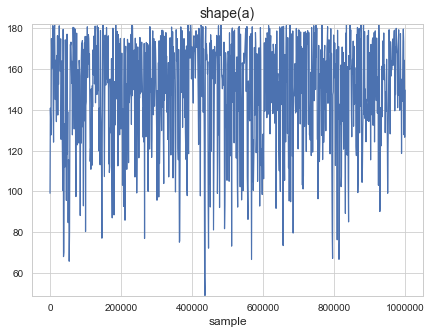

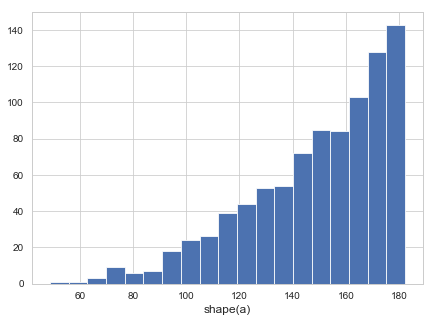

In [24]:
tracer.priSummary("shape(a)")

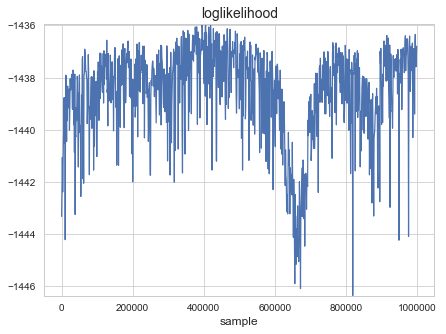

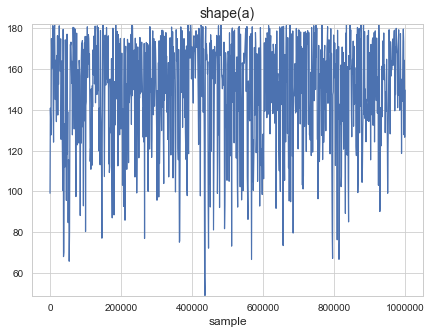

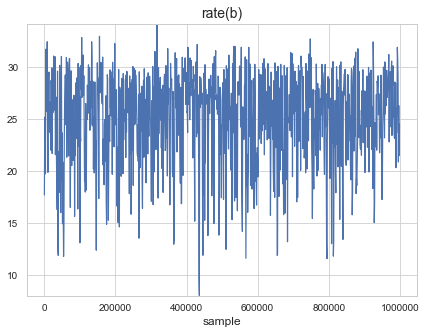

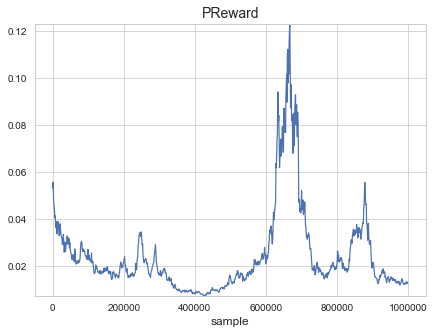

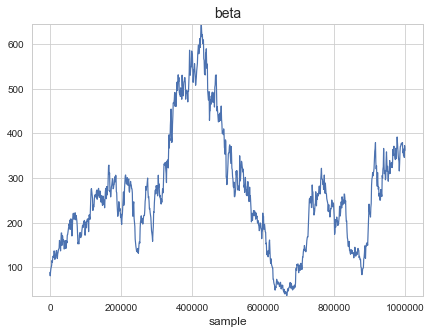

In [25]:
tracer.pltSample()

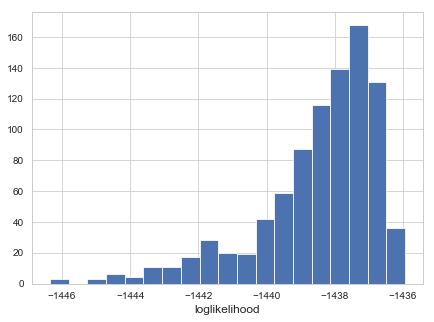

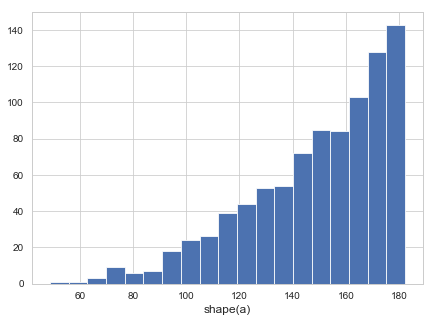

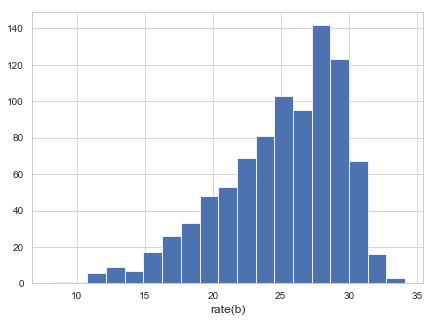

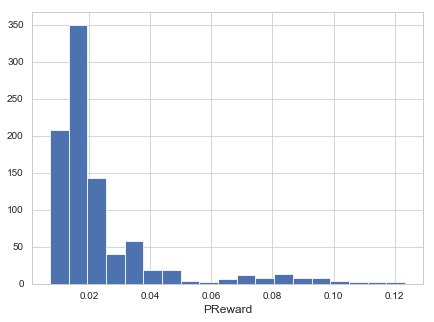

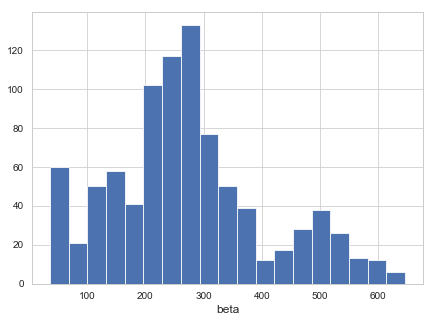

In [26]:
tracer.pltHist()

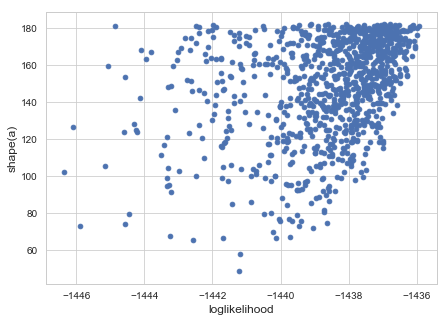

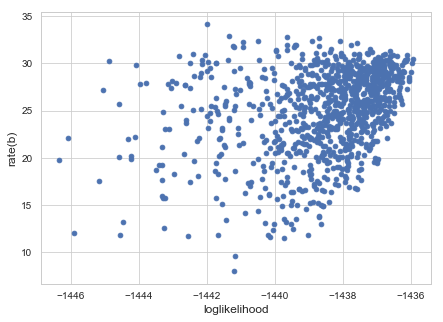

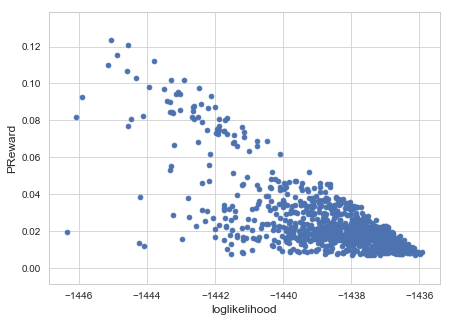

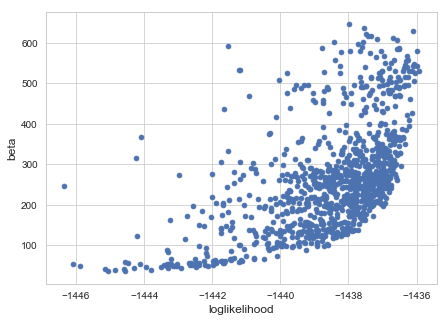

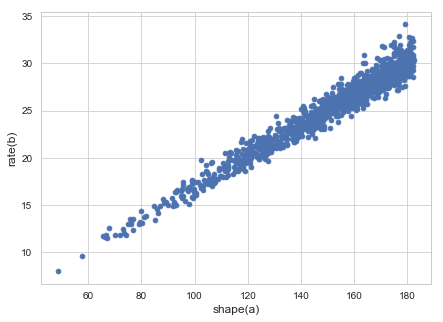

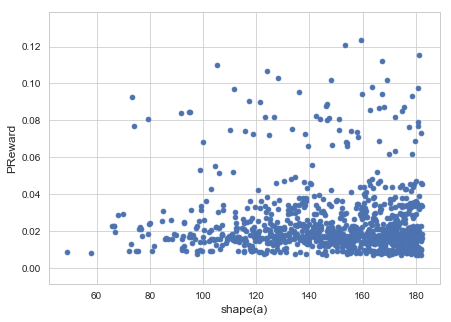

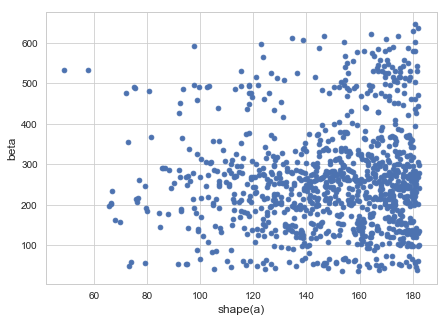

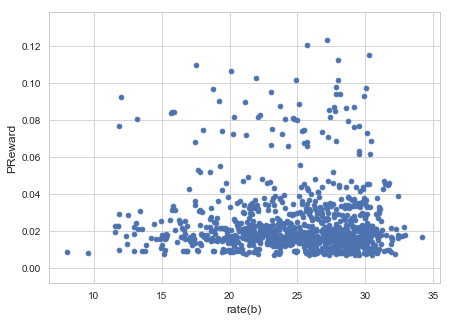

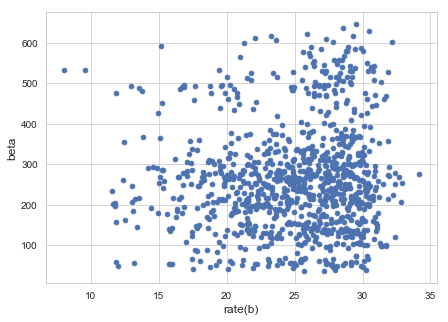

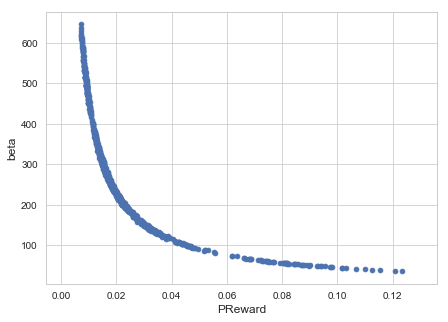

In [27]:
tracer.scatterAll()

In [28]:
import scipy.stats as stats 
from scipy.stats import gamma

def pr_all(bins = 200,beta = 50,a = 10,b = 2,PRewards =[0.25,0.35,0.5,0.75,0.9] ):
    t = np.linspace(0,20,bins)
    tau = t[1] - t[0]
    gm = gamma(a=  a,scale = 1/b)
    print("shape(a) : ",a,",rate(b) : ",b)
    print("tau :",t[1] - t[0])
    y = gm.pdf(t)
    yy = 1 - gm.cdf(t)


    plt.plot(t,y,label="Reward timing, pdf of N($\mu,\sigma$)")
    plt.plot(t,yy,label  ="Likelihood,1 - cdf of N($\mu,\sigma$)")
    plt.xlabel("time")
    plt.ylabel("Likelihood")
    plt.legend()
    plt.title("Fig 7a top")
    plt.show()

    # Fig 7A middle
    for PReward in PRewards:
        PPosterior = PReward*yy/( PReward*yy + 1- PReward )
        plt.plot(t,PPosterior,label=str(PReward))
    plt.ylim([0,1])
    plt.xlabel("time")
    plt.ylabel("Posterior")
    plt.title("Fig 7a middle")
    plt.legend(title="prior prob. for reward")
    plt.show()

    # P(wait|reward)
    for PReward in PRewards:
        PPosterior = PReward*yy/( PReward*yy + 1-PReward  )
        PWait =   1 / (1 + np.exp(-beta*PPosterior))
        plt.plot(t,PWait,label=str(PReward))
    plt.ylim([0,1])
    plt.xlabel("time")
    plt.ylabel("P(wait|t)")
    plt.legend(title="prior prob. for reward")
    plt.title("P(wait|t)")
    plt.show()

    # probability of quitting 
    for PReward in PRewards:
        PPosterior = PReward*yy/( PReward*yy + 1-PReward  )
        PWait =   1 / (1 + np.exp(-beta*PPosterior))
        Pwaitings = [1]
        Pquit = []
        for pw in PWait:
            Pquit.append(Pwaitings[-1]*(1-pw))
            Pwaitings.append(Pwaitings[-1]*pw)
        plt.plot(t,Pquit,label=str(PReward))

    plt.xlabel("time")
    plt.ylabel("wait time distribution of quit")
    plt.legend(title="prior prob. for reward")
    plt.title("Fig 7a bottom. Waiting, Prob. of quit")
    plt.show()


In [33]:
tracer.priSummary()

par_name : mean (lower;upper), HPD95 percent 
loglikelihood : -1438.498000 (-1442.404000 ; -1436.063000)
shape(a) : 149.129000 (96.308000 ; 182.281000)
rate(b) : 25.031000 (15.728000 ; 31.974000)
PReward : 0.024000 (0.007000 ; 0.073000)
beta : 273.770000 (43.415000 ; 532.317000)


In [30]:
r = tracer.res

shape(a) :  149.129 ,rate(b) :  25.031
tau : 0.10050251256281408


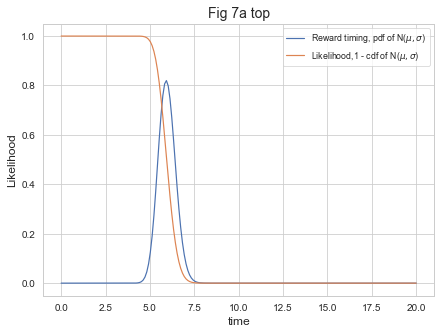

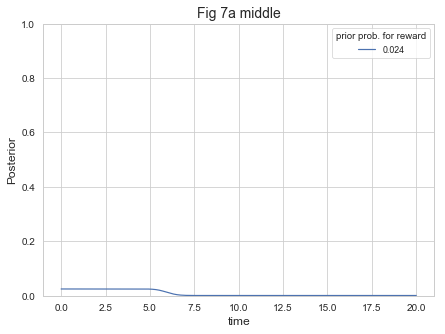

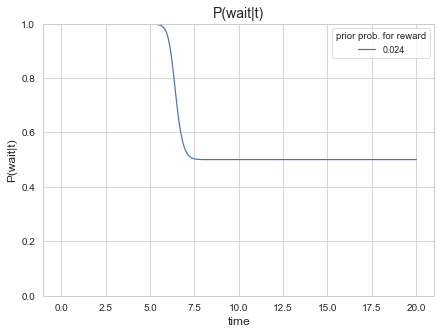

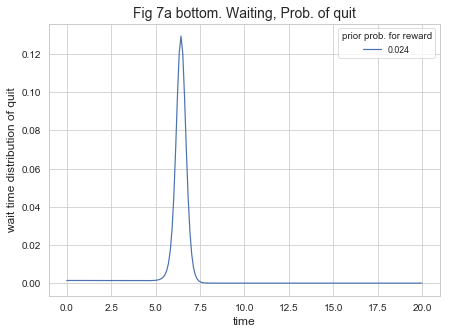

In [31]:
pr_all(a = r["shape(a)"]["mean"],b= r["rate(b)"]["mean"],PRewards = [r["PReward"]["mean"]],
       beta =r["beta"]["mean"])